In [1]:
# Only needed to run on AMD CPU
!export MKL_DEBUG_CPU_TYPE=5 

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt

from utility import get_data, plot_images, plot_image_pairs, get_train_val_pair

logging.getLogger().setLevel(logging.INFO)

In [3]:
REFRESH_DATA = False
data = get_data(REFRESH_DATA)

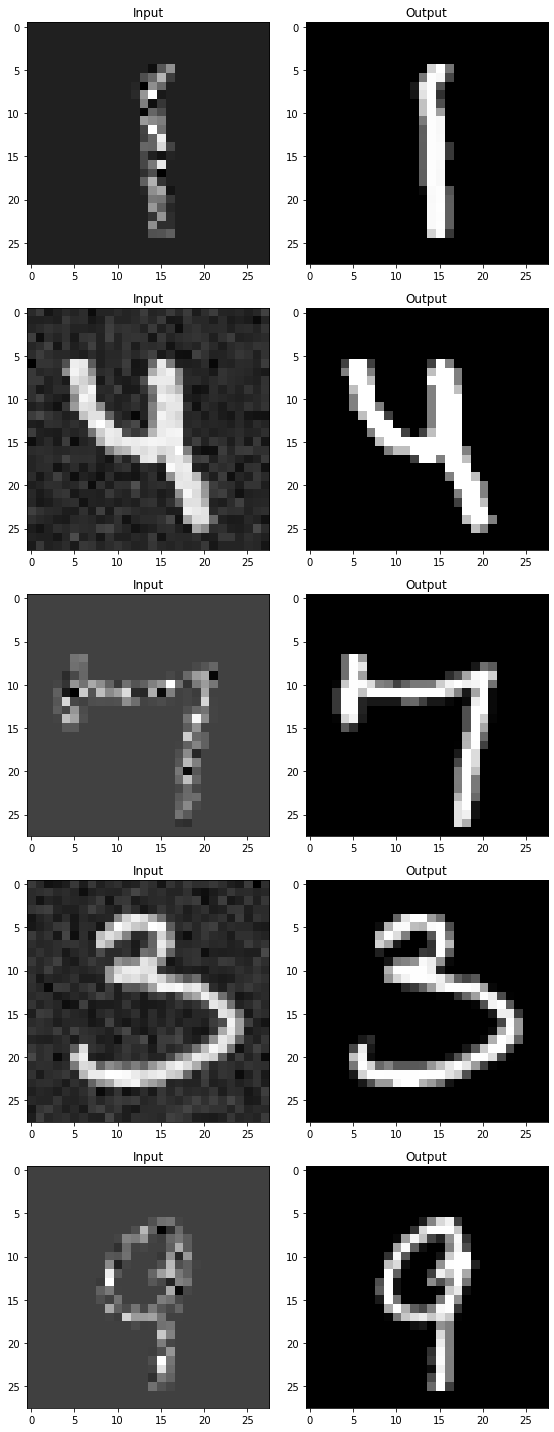

In [4]:
plot_image_pairs(data, ('Input', 'Output'))

In [5]:
(x_train, y_train), (x_val, y_val) = get_train_val_pair(data)
logging.info(f"Total training images: {len(x_train)}")
logging.info(f"Total validation images: {len(x_val)}")

INFO:root:Total training images: 238000
INFO:root:Total validation images: 42000


In [6]:
image_shape = x_train.shape[-2:]
total_pixels = np.prod(image_shape)

In [7]:
SEED = 666
initializers = {
    'random_normal_0': tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.05, seed=SEED),
    'random_normal_1': tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.1, seed=SEED),
    'random_uniform': tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=SEED),
    'truncated_normal': tf.keras.initializers.TruncatedNormal(mean=0.5, stddev=0.05, seed=SEED),
    'zero': tf.keras.initializers.Zeros(),
    'ones': tf.keras.initializers.Ones(),
    'GlorotNormal': tf.keras.initializers.GlorotNormal(seed=SEED),
    'GlorotUniform': tf.keras.initializers.GlorotUniform(seed=SEED),
    'identity': tf.keras.initializers.Identity(gain=1.0),
    'orthogonal': tf.keras.initializers.Orthogonal(gain=1.0, seed=SEED),
    'constant_point5': tf.keras.initializers.Constant(value=0.5)
}


In [8]:
def create_model(initializer):
    inputs = keras.Input(shape=image_shape, name='input_layer')
    flatten = keras.layers.Flatten(name='flatten_input_layer')(inputs)
    h1 = keras.layers.Dense(128, activation='sigmoid', name='hidden_layer_1', kernel_initializer=initializer) (flatten)
    outputs = keras.layers.Dense(total_pixels, activation='relu', name='output_layer', kernel_initializer=initializer) (h1)
    reshape =  keras.layers.Reshape((28,28), name='reshape_output_layer') (outputs)
    model = keras.Model(inputs=inputs, outputs=reshape, name = 'MLP')
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='MSE',
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    return model

In [9]:
earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=3
)

performance_stats = {}

for initializer_name, initializer in initializers.items():
    print(f'working on {initializer_name}')
    model = create_model(initializer)
    history = model.fit(
        x_train, 
        y_train, 
        batch_size = 512,
        epochs=100,
        validation_split=0.2,
        use_multiprocessing=True,
        callbacks=[earlystop_callback],
        verbose = 1
                    )
    performance_stats[initializer_name] = model.evaluate(x_val,  y_val, verbose=1)[1]

working on random_normal_0
Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
output_layer (Dense)         (None, 784)               101136    
_________________________________________________________________
reshape_output_layer (Reshap (None, 28, 28)            0         
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
Train on 190400 samples, validate on 47600 samples
Epoch 1/100
190400/190400 [==================

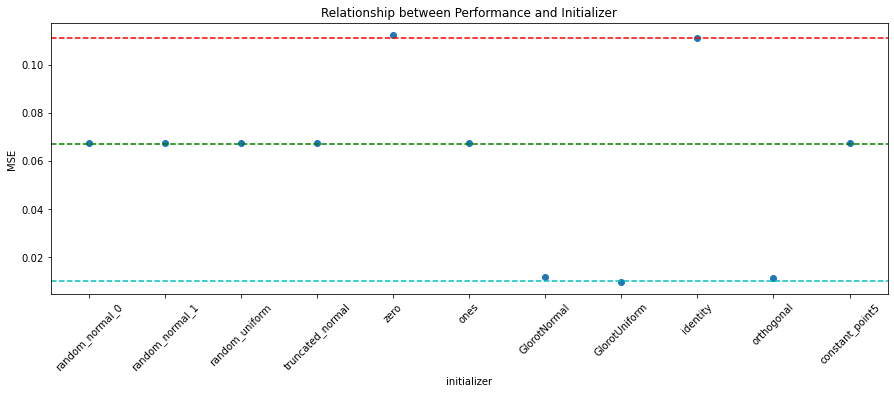

In [11]:
mse = list(performance_stats.values())
keys = performance_stats.keys()

figure, ax = plt.subplots(figsize=(15, 5))
ax.set_xticks(range(0,len(keys)))
ax.set_xticklabels(keys)
ax.ticklabel_format(useOffset=False, axis = 'y')
ax.scatter(keys, mse)
ax.set_xlabel('initializer')
plt.xticks(rotation=45)
plt.axhline(y=0.111, color = 'r', linestyle = '--')
plt.axhline(y=0.067, color = 'g', linestyle = '--')
plt.axhline(y=0.01, color = 'c', linestyle = '--')
ax.set_ylabel('MSE')
ax.set_title("Relationship between Performance and Initializer")
plt.show()

In [12]:
inputs = keras.Input(shape=image_shape, name='input_layer')
flatten = keras.layers.Flatten(name='flatten_input_layer')(inputs)
h1 = keras.layers.Dense(128, activation='relu', name='hidden_layer_1') (flatten)
h2 = keras.layers.Dense(256, activation='relu', name='hidden_layer_2') (h1)
h3 = keras.layers.Dense(512, activation='relu', name='hidden_layer_3') (h2)
outputs = keras.layers.Dense(total_pixels, activation='relu', name='output_layer') (h3)
reshape =  keras.layers.Reshape((28,28), name='reshape_output_layer') (outputs)
model = keras.Model(inputs=inputs, outputs=reshape, name = 'MLP')
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='MSE',
    metrics=['accuracy']
)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 512)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 784)               402192    
_________________________________________________________________
reshape_output_layer (Reshap (None, 28, 28)            0       

In [13]:
!rm -rf ./logs/

In [14]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1
)

earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=3
)

history = model.fit(
    x_train, 
    y_train, 
    batch_size = 256,
    epochs=50,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback, earlystop_callback]
)

Train on 190400 samples, validate on 47600 samples
Epoch 1/50
190400/190400 [==============================] - 33s 175us/sample - loss: 0.0180 - accuracy: 0.5131 - val_loss: 0.0125 - val_accuracy: 0.5576
Epoch 2/50
190400/190400 [==============================] - 26s 135us/sample - loss: 0.0114 - accuracy: 0.5626 - val_loss: 0.0107 - val_accuracy: 0.5704
Epoch 3/50
190400/190400 [==============================] - 25s 134us/sample - loss: 0.0100 - accuracy: 0.5741 - val_loss: 0.0099 - val_accuracy: 0.5757
Epoch 4/50
190400/190400 [==============================] - 26s 136us/sample - loss: 0.0092 - accuracy: 0.5810 - val_loss: 0.0092 - val_accuracy: 0.5827
Epoch 5/50
190400/190400 [==============================] - 26s 138us/sample - loss: 0.0087 - accuracy: 0.5865 - val_loss: 0.0086 - val_accuracy: 0.5901
Epoch 6/50
190400/190400 [==============================] - 27s 141us/sample - loss: 0.0083 - accuracy: 0.5910 - val_loss: 0.0083 - val_accuracy: 0.5925
Epoch 7/50
190400/190400 [=====

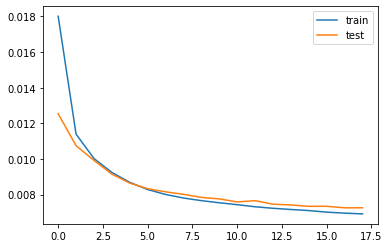

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
model.evaluate(x_val,  y_val, verbose=2)

42000/42000 - 3s - loss: 0.0073 - accuracy: 0.6041


[0.007262759815546728, 0.60405016]

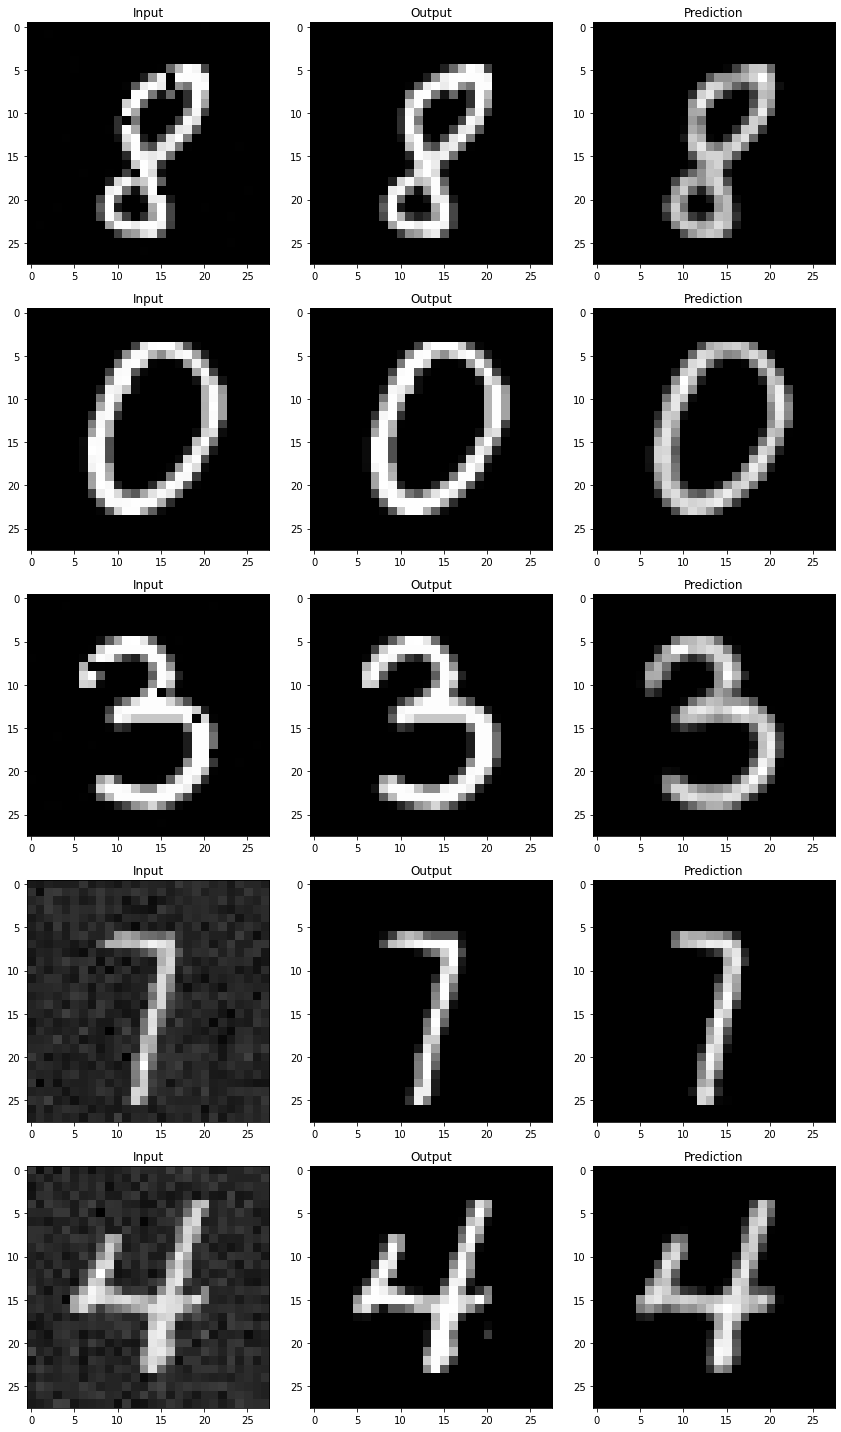

In [17]:
y_val_pred = model.predict(x_val)
plot_image_pairs((x_val, y_val, y_val_pred), ('Input', 'Output','Prediction'))

In [18]:
model.layers[-2].get_weights()[0].shape

(512, 784)

In [19]:
output_layer_weights = model.layers[-2].get_weights()[0]
output_layer_weights = output_layer_weights.reshape(-1, 28, 28)

Output Layer Weights images:


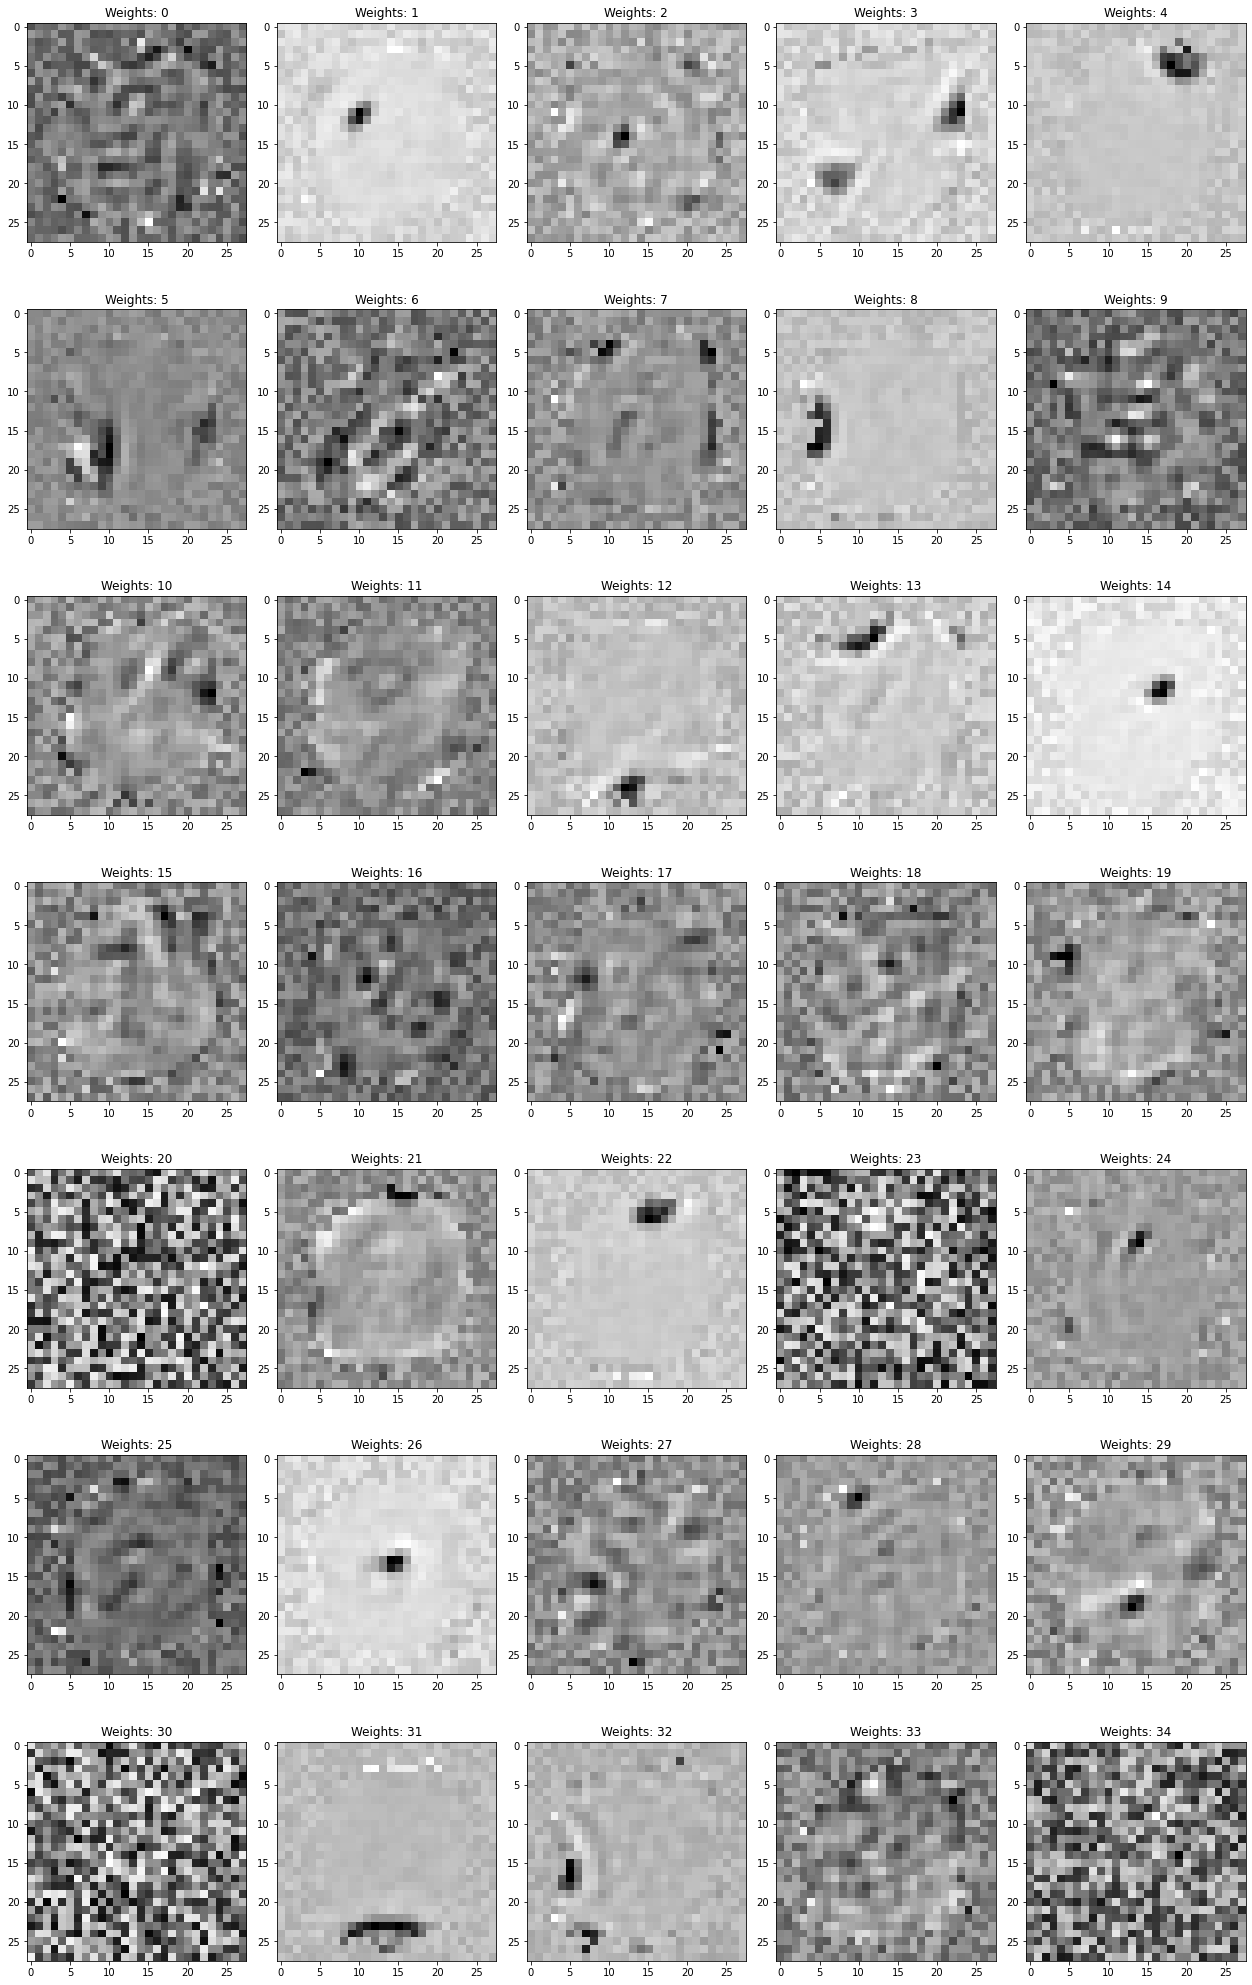

In [20]:
print("Output Layer Weights images:")
plot_images(output_layer_weights)